# This notebooks contains:
- some useful Bayes Factors (R's) that can be used for various sequential analysis use cases.  
- an 'web traffic' A/B testing example

In [16]:
!pip install numpy
!pip install scipy
!pip install rpy2

In [17]:
# general - e.g., math functions for binomial BF
import numpy as np
import scipy
from scipy.special import betainc
# for bayes factor t-test
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
import pandas as pd
import random # for random seed
import matplotlib.pyplot as plt # for plotting stuff
import pylab as pl
import math

pandas2ri.activate() # https://stackoverflow.com/questions/67028334/using-rpy2-cannot-find-r-package-that-is-installed
utils = importr("utils")
package_name = "BayesFactor"
utils.install_packages(package_name)
# import the BayesFactor package
BayesFactor = importr('BayesFactor')

R[write to console]: Warning:
R[write to console]:  package 'BayesFactor' is in use and will not be installed



In [19]:
def binomial_BF(A,B):
# Parameters:
# A (int): A decimal integer
# B (int): Another decimal integer
# Returns:
# log of the Bayes Factor (likelihood ratio) = log(Prob(A,B|A and B are derived from different binomial probabilities)) - log(Prob(A,B|A and B are derived from the same binomial probability))
  log_denom = (A+B)*np.log(0.5)
  log_num = scipy.special.loggamma(A+1)+scipy.special.loggamma(B+1)-scipy.special.loggamma(A+B+2)
  return log_num-log_denom

In [20]:
def binomial_BF_inc(A,N,p_T):
# Parameters:
# A (int): number of clicks
# N (int): total number of visits
# Returns:
# bayes Factor (likelihood ratio) = Prob(A,N|group A has mean greater than p_T)) - log(Prob(A,N|group A has mean less than p_T)
  return ((1-betainc(A+1,N-A+1,p_T))/(1-p_T))/(betainc(A+1,N-A+1,p_T)/p_T)    

In [21]:
def dual_binomial_BF(A,N_A,B,N_B):
# Parameters:
# A (int): number of customers who click site A
# N_A (int): number of customers driven to site A
# B (int): number of customers who click site B
# N_B (int): number of customers driven to site B
# Returns:
# Bayes Factor (likelihood ratio) = 
#    Prob(A,B|p_A!=p_B) / Prob(A,B|p_A=p_B)
  log_denom = scipy.special.loggamma(A+B+1)+scipy.special.loggamma(N_A+N_B-A-B+1)-scipy.special.loggamma(N_A+N_B+2) 
  log_num  = scipy.special.loggamma(A+1)+scipy.special.loggamma(N_A-A+1)-scipy.special.loggamma(N_A+2)    
  log_num += scipy.special.loggamma(B+1)+scipy.special.loggamma(N_B-B+1)-scipy.special.loggamma(N_B+2)    
  return log_num-log_denom
    

In [22]:
# see https://statsthinking21.github.io/statsthinking21-python/10-BayesianStatistics.html
def bayesian_t_test(A_list,B_list):
# Parameters:
# A (int): A decimal integer
# B (int): Another decimal integer
# p (float):probability threshold
# Returns:
# Bayes Factor (likelihood ratio) = 
#    Prob(A,B|binomial probability of A >p and binomial probability of B < p ) / Prob(A,B|binomial probability of A <p and binomial probability of B > p)

  robjects.globalenv["A_list"] = np.array(A_list)
  robjects.globalenv["B_list"] = np.array(B_list)

  # compute the Bayes factor
  r('bf = ttestBF(y=A_list, x=B_list, nullInterval = c(0, Inf))')
  return r('bf@bayesFactor$bf[1]')[0]
#  
  print("bf_num=",bf_num)
#  print("HELLO WORLD")
#  return r('print(bf[1]/bf[2])')



In [23]:
def convert_BF_to_posterior(BF):
    return BF/(1+BF)


def binomial_BF_inc_err(A,N,pT):
    binomial_error=np.sqrt(N*(A/N)*(1-A/N))
    return binomial_BF_inc(A,N,pT),binomial_BF_inc(A-binomial_error,N,pT),binomial_BF_inc(A+binomial_error,N,pT)
    

## Define Functions

Creates an experiment with N customers (n observations) that are driven to either website A or website B.  
if p_A is the probability of clicking website A and p_B is the probability of clicking website B, 
threshold = p_A/(p_A+p_B)
The Bayes factor is the probability that p_A and p_B are anything over the probability that p_A=p_B.
In other words, it's the probabilty that threshold=[0,1] over the probability that threshold=0.5.

  BF = \frac{\int_0^1 dp_A p_A^A(1-p_A)^{N_A} \int_0^1 dp_B p_B^B(1-p_B)^{N_B}{0.5^A(1-0.5)^{N_A} \int_0^1 dp_B 0.5^B(1-0.5)^{N_B}}

These are some example likelihood ratios that you can use for sequential analysis.  They include 
- binomial_DF: takes two Poisson distributed integers and calculates the likelihood that they have different means over the likelihood that they have the same mean
- binomial_BF_inc: takes two Poisson distributed integers and calculates the likelihood that the binomial mean p is greater than the threshold pT
- bayesian_t_test: takes two lists of Gaussian-distributed numbers and determines the likelihood that they have different means over the likelihood that they have the same mean    
- dual_binomial_BF: returns the probability that the means of two binomial distributions are different over the probability that they are the same  

In [18]:
def create_web_AB_experiment(n_observations,p_A,p_B):
# returns: list of BF's
  sequential_df = pd.DataFrame()
  sequential_df['row_number'] = [x for x in range(N_total_customers)]
  sequential_df['customer_A_or_B'] = [('A' if random.uniform(0, 1)<0.5 else 'B') for x in range(N_total_customers)]
  sequential_df['random_number'] = [random.uniform(0,1) for x in range(N_total_customers)]
  sequential_df['passes_threshold'] = [-1]*N_total_customers # initialize
  sequential_df.loc[sequential_df['customer_A_or_B']=='A', 'passes_threshold'] = (sequential_df.loc[sequential_df['customer_A_or_B']=='A', 'random_number']<p_A)*1
  sequential_df.loc[sequential_df['customer_A_or_B']=='B', 'passes_threshold'] = (sequential_df.loc[sequential_df['customer_A_or_B']=='B', 'random_number']<p_B)*1
  sequential_df['cumulative_A'] = [np.sum(sequential_df['customer_A_or_B'][:i]=='A') for i in sequential_df['row_number']]
  sequential_df['cumulative_B'] = [np.sum(sequential_df['customer_A_or_B'][:i]=='B') for i in sequential_df['row_number']]
  sequential_df['cumulative_passes_threshold_A'] = [np.sum(sequential_df['passes_threshold'][:i]*(sequential_df['customer_A_or_B']=='A')) for i in sequential_df['row_number']]
  sequential_df['cumulative_passes_threshold_B'] = [np.sum(sequential_df['passes_threshold'][:i]*(sequential_df['customer_A_or_B']=='B')) for i in sequential_df['row_number']]
  BF = [dual_binomial_BF(x[0],x[1],x[2],x[3]) for x in zip(sequential_df['cumulative_passes_threshold_A'],sequential_df['cumulative_A'],sequential_df['cumulative_passes_threshold_B'],sequential_df['cumulative_B'])]  
  return BF


        

# Do simple sequential analysis
We simulate a simple A/B test scenario.  Two web pages are created.  50% of customer traffic is driven to website A and 50% to website B.  We then want to determine whether the probability of clicking an ad is greater on website A than website B.  

The simulated data is created in a slightly unintuitive way.  A random number is generated between 0 and 1.  threshold is the probability the relative probability of a person clicking website A over website B.  
Specifically, we
1.  create dataframe with column with randomly generated numbers between 0 and 1
2.  create column with thresholded 0's and 1's
3.  count cumulative values that pass threshold
4.  create column with number of row

In [29]:
alpha = 0.05 # alpha = type I error rate = sig. level
beta  = 0.2  # beta  = type II error rate = 1-power
p_A = 0.01
p_B = 0.02
# Wald threshold formulas for sequential analysis
lower_limit = np.log(beta)-np.log(1-alpha)
upper_limit = np.log(1-beta)-np.log(alpha)
print('log upper threshold:',lower_limit)
print('log lower threshold:',upper_limit)
print('upper threshold:',np.exp(lower_limit))
print('lower threshold:',np.exp(upper_limit))

log upper threshold: -1.5581446180465497
log lower threshold: 2.772588722239781
upper threshold: 0.21052631578947373
lower threshold: 15.999999999999998


In [25]:
N_total_customers = 10000

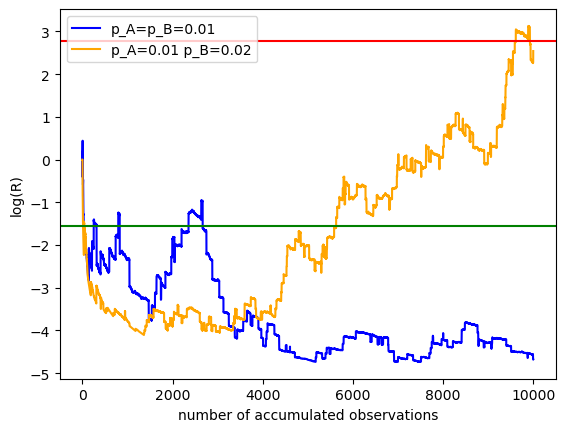

In [26]:
# plot results
random.seed(2)
even_probs = create_web_AB_experiment(N_total_customers,p_A=p_A,p_B=p_A)
uneven_probs = create_web_AB_experiment(N_total_customers,p_A=p_A,p_B=p_B)
plt.plot(range(N_total_customers),even_probs,color='blue',label='p_A=p_B='+str(p_A))
plt.plot(range(N_total_customers),uneven_probs,color='orange',label='p_A='+str(p_A)+' p_B='+str(p_B))
# upper limit
plt.axhline(y=lower_limit, color='g', linestyle='-')
plt.axhline(y=upper_limit, color='r', linestycle='-')
plt.xlabel('number of accumulated observations')
plt.ylabel('log(R)')
plt.legend(loc="upper left")
plt.show()

## Coin Flip Example

In [97]:
alpha = 0.05 # alpha = type I error rate = sig. level
beta  = 0.2  # beta  = type II error rate = 1-power
# Wald threshold formulas for sequential analysis
lower_limit = np.log(beta)-np.log(1-alpha)
upper_limit = np.log(1-beta)-np.log(alpha)
print('log upper threshold:',upper_limit)
print('log lower threshold:',lower_limit)
print('upper threshold:',np.exp(upper_limit))
print('lower threshold:',np.exp(lower_limit))

log upper threshold: 2.772588722239781
log lower threshold: -1.5581446180465497
upper threshold: 15.999999999999998
lower threshold: 0.21052631578947373


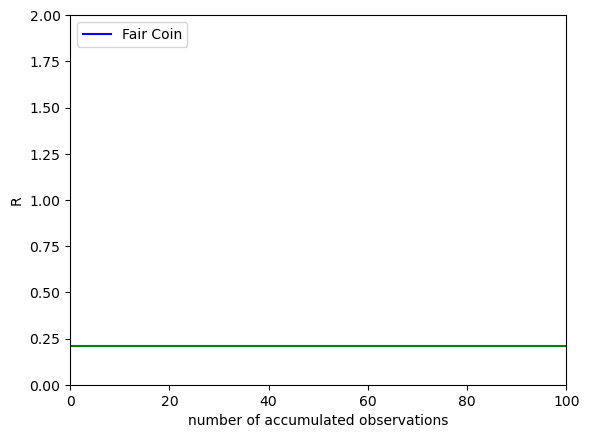

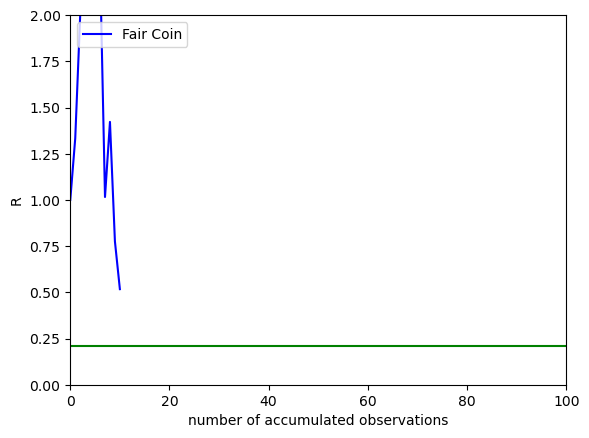

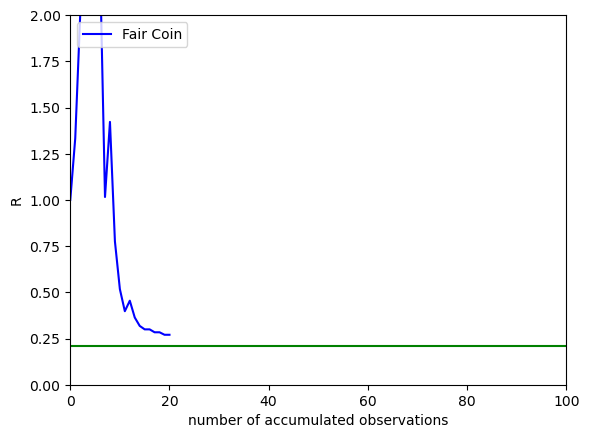

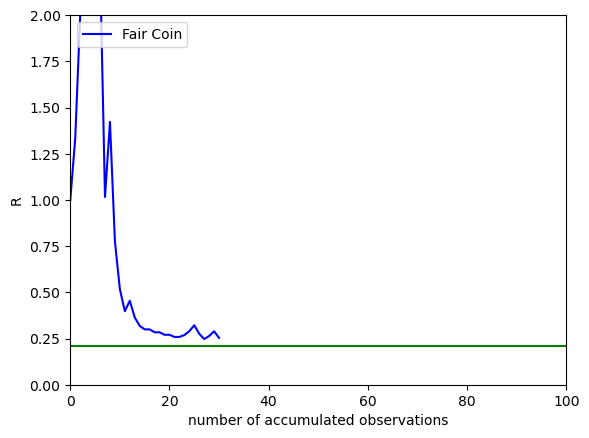

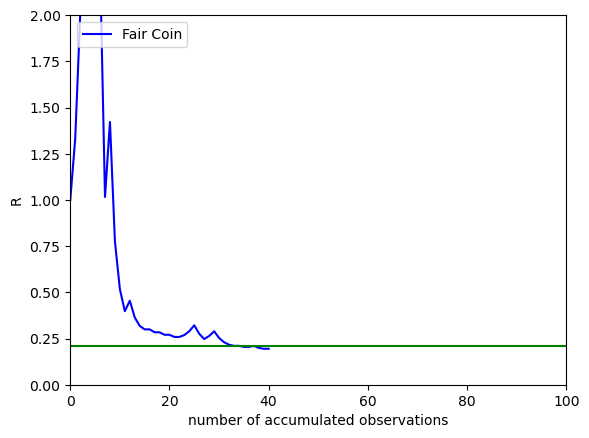

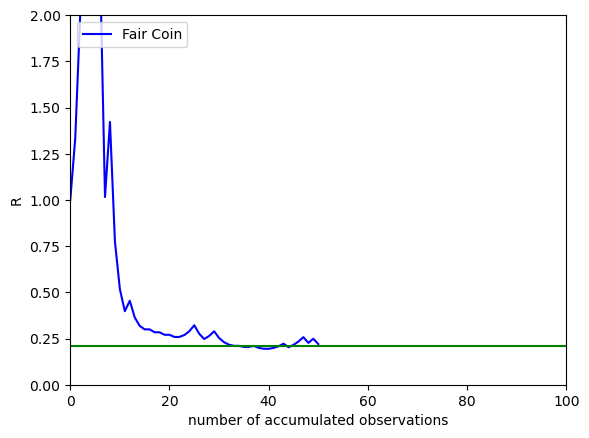

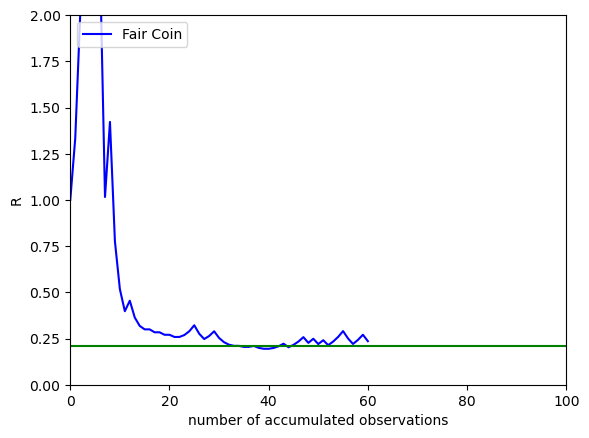

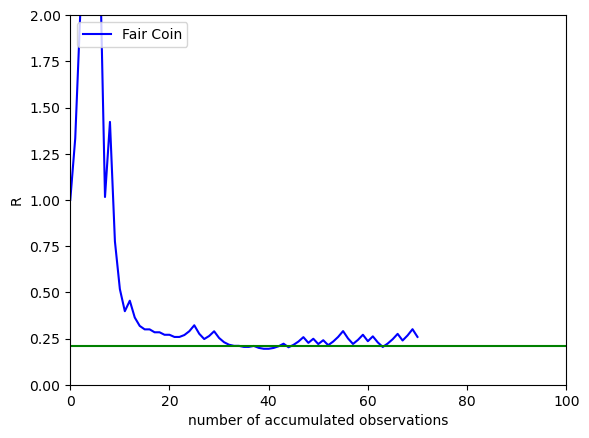

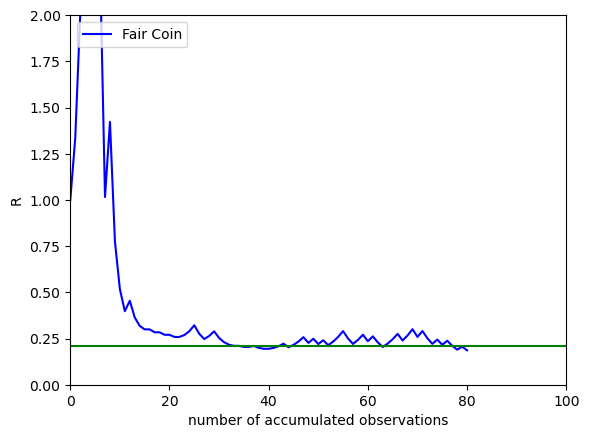

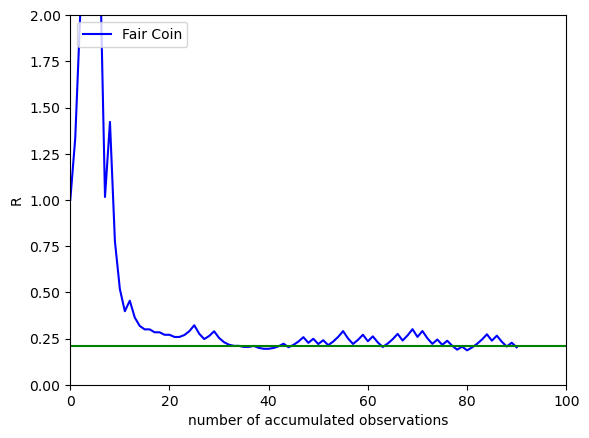

In [98]:
random.seed(1)
# fair coin
p_fair = 0.5
n_flips = 100
A=0
NA=0
BFs = []
for flip in range(n_flips):
    NA+=1
    if np.random.random()<p_fair:
        A+=1
    BF = np.exp(scipy.special.loggamma(A+1)+scipy.special.loggamma(NA-A+1)-scipy.special.loggamma(NA+2)-(NA*np.log(0.5)))
    BFs += [BF]
    if (flip % 10) == 0:
        plt.plot(range(flip+1),BFs,color='blue',label='Fair Coin')
    # upper limit
        plt.axhline(y=np.exp(lower_limit), color='g', linestyle='-')
        plt.axhline(y=np.exp(upper_limit), color='r', linestyle='-')
        plt.xlabel('number of accumulated observations')
        plt.ylabel('R')
        plt.legend(loc="upper left")
        plt.xlim([0, n_flips])
        plt.ylim([0, 2])
        plt.show()

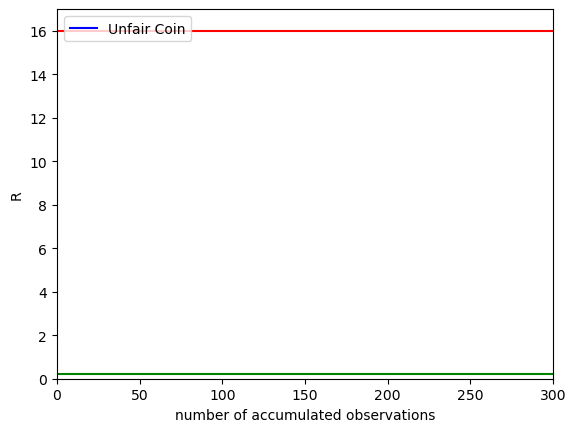

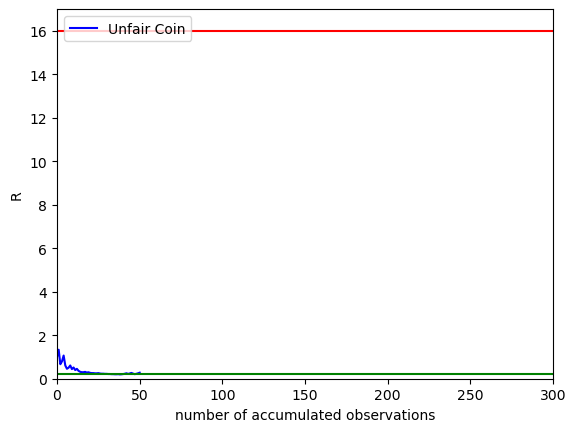

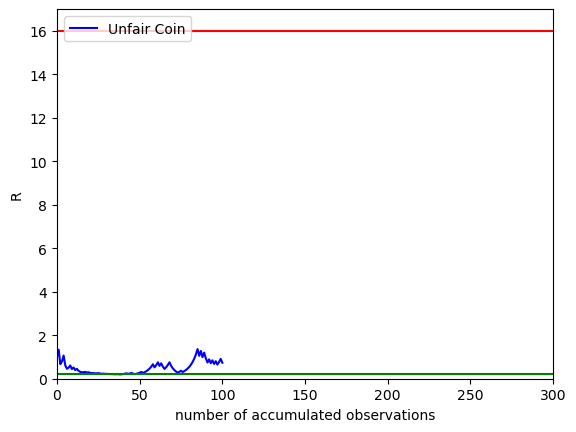

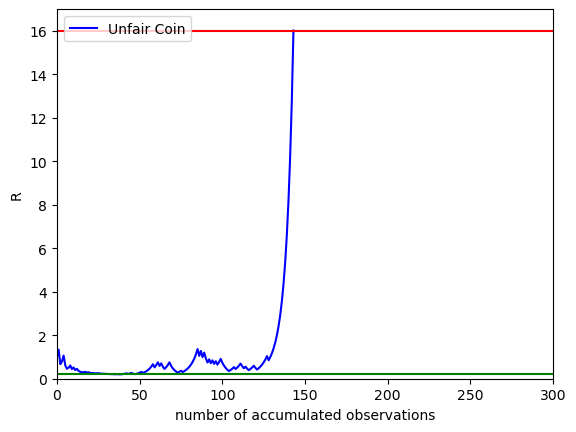

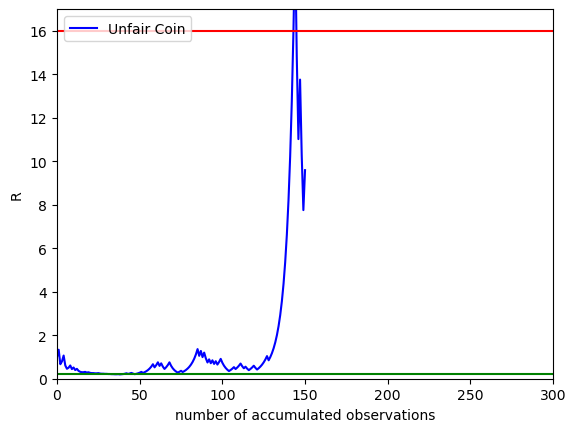

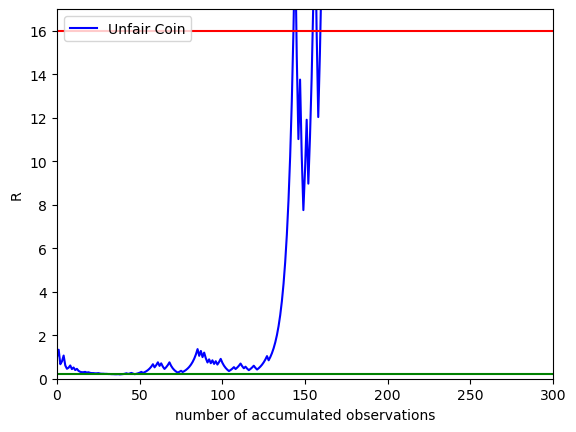

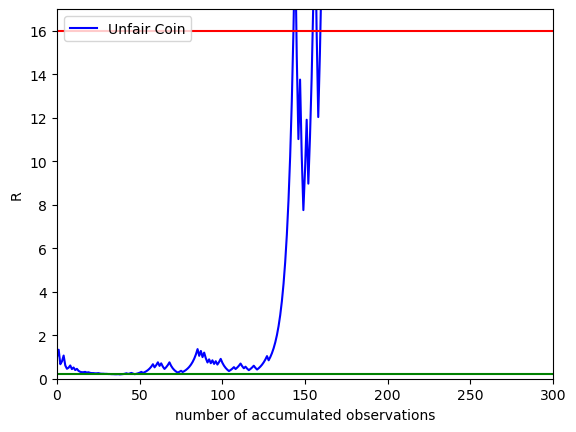

In [110]:
random.seed(1)
# unfair coin
p_unfair = 0.6
n_flips = 300
first_pass = 0
A=0
NA=0
BFs = []
for flip in range(n_flips):
    NA+=1
    if np.random.random()<p_unfair:
        A+=1
    BF = np.exp(scipy.special.loggamma(A+1)+scipy.special.loggamma(NA-A+1)-scipy.special.loggamma(NA+2)-(NA*np.log(0.5)))
    BFs += [BF]
    if BF>np.exp(upper_limit):
        first_pass+=1
    if ((flip % 50) == 0) or (first_pass==1):           
        plt.plot(range(flip+1),BFs,color='blue',label='Unfair Coin')
    # upper limit
        plt.axhline(y=np.exp(lower_limit), color='g', linestyle='-')
        plt.axhline(y=np.exp(upper_limit), color='r', linestyle='-')
        plt.xlabel('number of accumulated observations')
        plt.ylabel('R')
        plt.legend(loc="upper left")
        plt.xlim([0, n_flips])
        plt.ylim([0, 17])
        plt.show()

# References
## Bayesian t-test
- https://mspeekenbrink.github.io/sdam-r-companion/bayesian-hypothesis-testing-with-bayes-factors.html